<a href="https://colab.research.google.com/github/Shemonti/Breast-Histology-Images/blob/main/IDC_Image_classification_with_EANet__test_with_brekhis_64_40_epoch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import fnmatch
import os
import PIL
import glob
import tensorflow as tf
from matplotlib.image import  imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unrar x -Y "/content/drive/MyDrive/data_used (1).rar" 

Streaming output truncated to the last 5000 lines.
Extracting  data_used/IDC/12906_idx5_x1701_y1701_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1751_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1801_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1851_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1901_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y1951_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2001_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2151_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2201_class1.png               35%  OK 
Extracting  data_used/IDC/12906_idx5_x1701_y2251_class1.png               35%  OK 
Extracting  data_used/IDC/129

In [4]:
import pathlib
dt_dir='/content/data_used'
data_dir = pathlib.Path(dt_dir)
data_dir

PosixPath('/content/data_used')

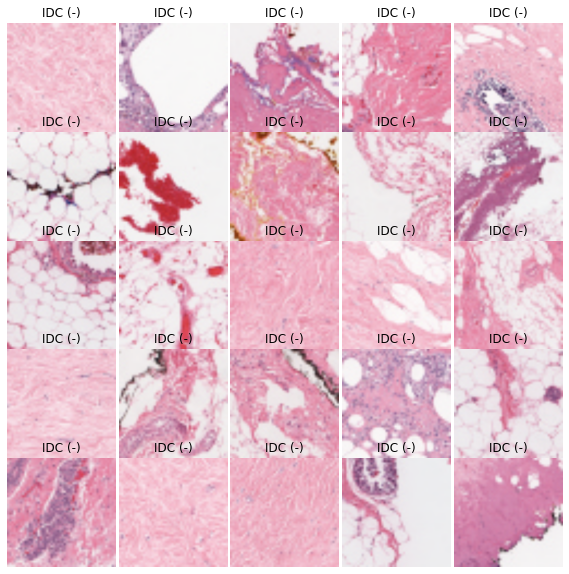

In [5]:
NORMAL=list(data_dir.glob('NORMAL/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in NORMAL[:25]:
    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('IDC (-)')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
     #.set_title(l)
     
    i_ += 1

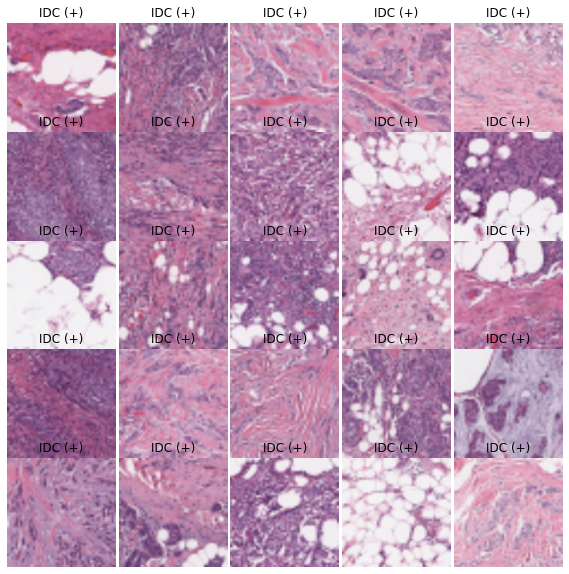

In [6]:
IDC=list(data_dir.glob('IDC/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in IDC[:25]:
   



    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('IDC (+)')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
     #.set_title(l)
     
    i_ += 1

In [7]:
breast_images_dict = {
    'IDC(-)': list(data_dir.glob('NORMAL/*.png')),
    'IDC(+)': list(data_dir.glob('IDC/*.png')),
    
}

In [8]:
breast_labels_dict = {
    'IDC(-)': 0,
    'IDC(+)': 1
   
}

In [9]:
X, y = [], []

for breast_name, images in breast_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        im = cv2.resize(img, (64, 64))
        X.append(im)
        y.append(breast_labels_dict[breast_name])

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
X.shape

(7500, 64, 64, 3)

In [12]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
len(y)

7500

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.3, random_state=42)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(5250, 64, 64, 3) (675, 64, 64, 3) (1575, 64, 64, 3) (5250,) (675,) (1575,)


In [16]:
y_val

array([1, 0, 1, ..., 0, 1, 0])

In [17]:
len(X_train)

5250

In [18]:
len(X_test)

675

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

In [20]:
data_augmentation = keras.Sequential(
  [
   layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(64, 
                                                              64,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

EANet

In [21]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [23]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
# validation_split = 0.2
batch_size = 128
num_epochs = 10
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (im.shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 1024


In [24]:
# class PatchExtract(layers.Layer):
#     def __init__(self, patch_size, **kwargs):
#         super(PatchExtract, self).__init__(**kwargs)
#         # self.patch_size = patch_size
#         self.patch_size = tf.Variable(patch_size, name="var_a")

#     # def get_config(self):
#     #     config = super().get_config()
#     #     config.update({
#     #         "patch_size": self.patch_size,
           
#     #     })
#     #     return config
      
#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=(1, self.patch_size, self.patch_size, 1),
#             strides=(1, self.patch_size, self.patch_size, 1),
#             rates=(1, 1, 1, 1),
#             padding="VALID",
#         )
#         patch_dim = patches.shape[-1]
#         patch_num = patches.shape[1]
#         return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

    
#     def get_config(self):
#         return {"patch_size": self.patch_size.numpy()}

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)

# layer = PatchExtract(5)
# layer.patch_size.assign(2)
# serialized_layer = keras.layers.serialize(layer)
# new_layer = keras.layers.deserialize(
#     serialized_layer, custom_objects={"PatchExtract": PatchExtract}
# )

In [25]:


# class PatchEmbedding(layers.Layer):
#     def __init__(self, num_patch, embed_dim, **kwargs):
#         super(PatchEmbedding, self).__init__(**kwargs)
#         self.num_patch = num_patch
#         self.proj = layers.Dense(embed_dim)
#         self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

#     # def get_config(self):
#     #     config = super().get_config()
#     #     config.update({
#     #         "num_patch": self.num_patch,
#     #         "layers.Dense(embed_dim)": self.proj,
#     #         "layers.Embedding(input_dim=num_patch, output_dim=embed_dim)": self.pos_embed,
           
#     #     })
#     #     return config    

#     def call(self, patch):
#         pos = tf.range(start=0, limit=self.num_patch, delta=1)
#         return self.proj(patch) + self.pos_embed(pos)


         
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "num_patch": self.num_patch,
#             "layers.Dense(embed_dim)": self.proj,
#             "layers.Embedding(input_dim=num_patch, output_dim=embed_dim)": self.pos_embed,
           
#         })
#         return config    

   

In [26]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [27]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [28]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [29]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [30]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=im.shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
model = get_model(attention_type="external_attention")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.compile(
#     loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
#     optimizer=tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     ),
#     metrics=[
#         keras.metrics.CategoricalAccuracy(name="accuracy"),
#         keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
#     ],
# )

# history = model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=num_epochs,
#     validation_split=validation_split,
# )

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [33]:
# filepath = "/content/drive/MyDrive/best_moel/mymodel_IDC_EANet_1.h5"
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, 
#                                              save_weights_only=False, mode='min')

# model.save('/content/drive/MyDrive/best_moel/mymodel_IDC_EANet_1.h5')
# print('Model Saved!')
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [34]:

history=model.fit(X_train_scaled, y_train, epochs=40,validation_data = (X_val_scaled,y_val))

Epoch 1/40
165/165 [==============================] - 61s 293ms/step - loss: 0.4795 - accuracy: 0.7996 - val_loss: 0.3315 - val_accuracy: 0.8889
Epoch 2/40
165/165 [==============================] - 43s 263ms/step - loss: 0.3052 - accuracy: 0.8792 - val_loss: 0.3182 - val_accuracy: 0.8768
Epoch 3/40
165/165 [==============================] - 43s 262ms/step - loss: 0.2717 - accuracy: 0.8920 - val_loss: 0.2537 - val_accuracy: 0.9041
Epoch 4/40
165/165 [==============================] - 43s 263ms/step - loss: 0.2345 - accuracy: 0.9029 - val_loss: 0.2329 - val_accuracy: 0.8984
Epoch 5/40
165/165 [==============================] - 44s 264ms/step - loss: 0.2340 - accuracy: 0.9072 - val_loss: 0.2459 - val_accuracy: 0.9111
Epoch 6/40
165/165 [==============================] - 43s 262ms/step - loss: 0.2232 - accuracy: 0.9082 - val_loss: 0.2175 - val_accuracy: 0.9137
Epoch 7/40
165/165 [==============================] - 43s 262ms/step - loss: 0.2243 - accuracy: 0.9086 - val_loss: 0.2601 - val_ac

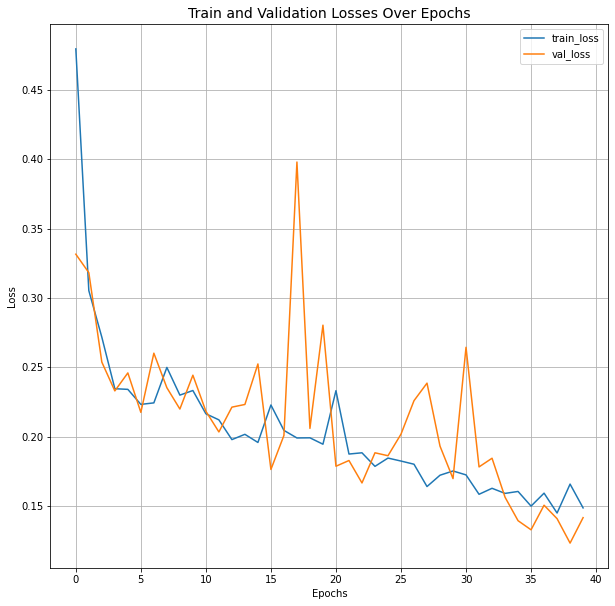

In [35]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [36]:
# model = load_model("/content/drive/MyDrive/best_moel/mymodel_IDC_EANet_1.h5")

In [37]:
model.evaluate(X_test_scaled,y_test)

22/22 [==============================] - 2s 88ms/step - loss: 0.1506 - accuracy: 0.9363


[0.15055851638317108, 0.936296284198761]

In [38]:
predictions = model.predict(X_test_scaled)
predictions[:5]

22/22 [==============================] - 4s 88ms/step


array([[9.9999642e-01, 3.5559269e-06],
       [9.9976307e-01, 2.3687971e-04],
       [2.1162201e-02, 9.7883785e-01],
       [1.1646067e-02, 9.8835397e-01],
       [1.6602491e-03, 9.9833977e-01]], dtype=float32)

In [39]:
y_pred = [np.argmax(element) for element in predictions]
y_pred[:5]

[0, 0, 1, 1, 1]

In [40]:
from sklearn.metrics import classification_report,confusion_matrix

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       416
           1       0.98      0.85      0.91       259

    accuracy                           0.94       675
   macro avg       0.95      0.92      0.93       675
weighted avg       0.94      0.94      0.94       675



In [42]:
confusion=(confusion_matrix(y_test,y_pred))

Text(87.0, 0.5, 'Truth')

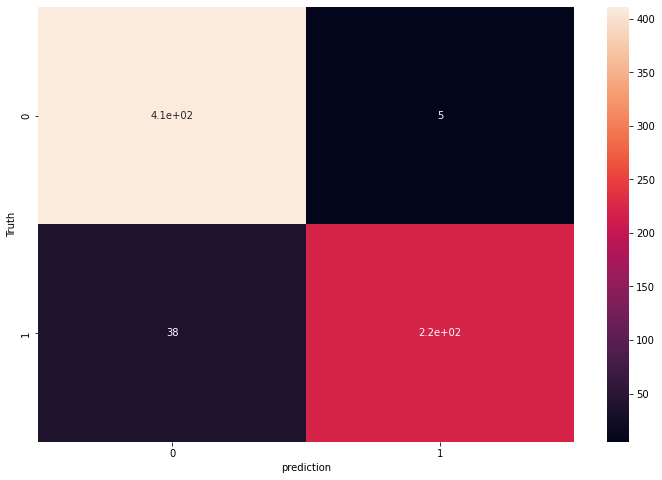

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion,annot=True)
plt.xlabel('prediction')
plt.ylabel('Truth')#depthwiseunit_depthwise_kernel=5

In [44]:
from sklearn import metrics

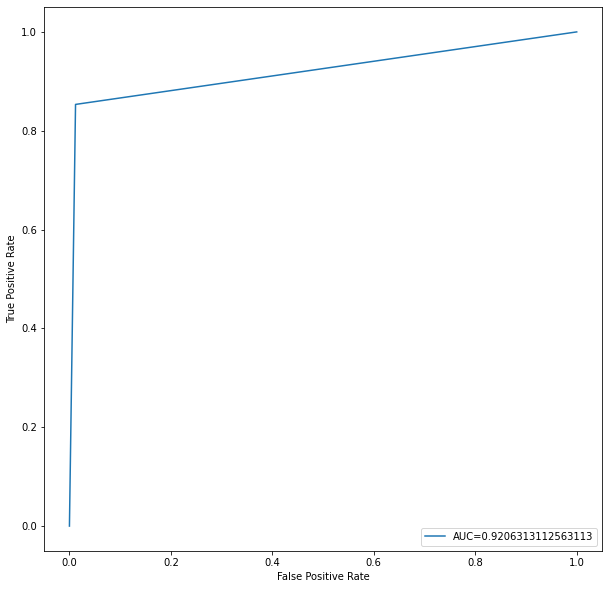

In [45]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

BreakHis

In [46]:
dataset_url = "http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz"
data_dir = tf.keras.utils.get_file('histology_slides', origin=dataset_url,  cache_dir='.', untar=True)

4273561758/4273561758 [==============================] - 294s 0us/step


In [47]:
import shutil
import glob
import matplotlib.pyplot as plt
import json
import math
import cv2
import os

In [48]:
os.mkdir('augmented')

In [49]:
os.mkdir('/content/augmented/benign')
os.mkdir('/content/augmented/malignant')

In [50]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [51]:
files_benign=getListOfFiles('/content/datasets/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')

In [52]:
files_malignant=getListOfFiles('/content/datasets/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [53]:
import pathlib
dt_dir='/content/augmented'
data_dir = pathlib.Path(dt_dir)
data_dir

PosixPath('/content/augmented')

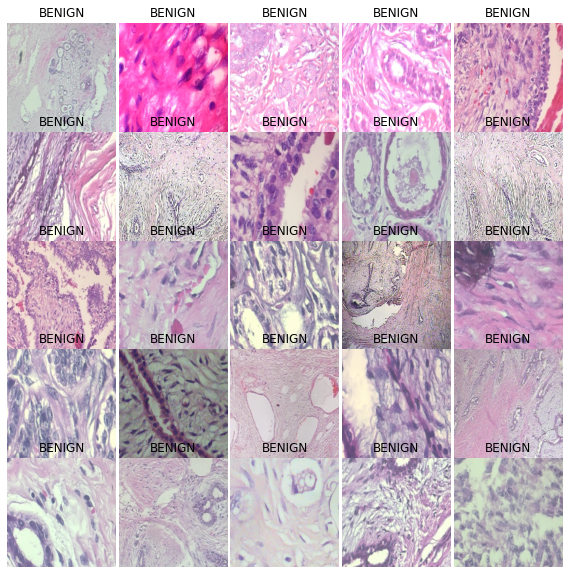

In [54]:
BENIGN=list(data_dir.glob('benign/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in BENIGN[:25]:
    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('BENIGN')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
    #.set_title(l)
    i_ += 1

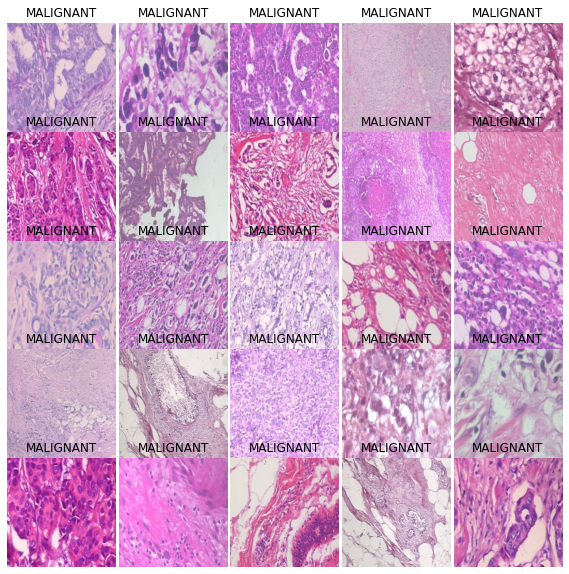

In [55]:
MALIGNANT=list(data_dir.glob('malignant/*.png'))
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for imgname in MALIGNANT[:25]:
    im = cv2.imread(str(imgname))
    im = cv2.resize(im, (227, 227)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.axis('off')        
    plt.title('MALIGNANT')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB));
    #.set_title(l)
    i_ += 1

In [56]:
len(MALIGNANT)

5429

In [57]:
breast_images_dict = {
    'BENIGN': list(data_dir.glob('benign/*.png')),
    'MALIGNANT': list(data_dir.glob('malignant/*.png')),
    
}

In [58]:
breast_labels_dict = {
    'BENIGN': 0,
    'MALIGNANT': 1
   
}

In [59]:
X1, y1 = [], []

for breast_name, images in breast_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        im = cv2.resize(img, (64, 64))
        X1.append(im)
        y1.append(breast_labels_dict[breast_name])

In [60]:
X1 = np.array(X)
y1 = np.array(y)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)

(6000, 64, 64, 3) (1500, 64, 64, 3) (6000,) (1500,)


In [62]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
# X_val_scaled = X_val / 255

In [63]:
model.evaluate(X_test_scaled,y_test)

47/47 [==============================] - 5s 90ms/step - loss: 0.1395 - accuracy: 0.9467


[0.1394554078578949, 0.9466666579246521]

In [64]:
predictions = model.predict(X_test_scaled)
predictions[:5]

47/47 [==============================] - 4s 88ms/step


array([[9.9998212e-01, 1.7868537e-05],
       [5.7615578e-04, 9.9942386e-01],
       [9.9953294e-01, 4.6705169e-04],
       [6.8497324e-01, 3.1502673e-01],
       [8.8088273e-04, 9.9911910e-01]], dtype=float32)

In [65]:
y_pred = [np.argmax(element) for element in predictions]
y_pred[:5]

[0, 1, 0, 0, 1]

In [66]:
from sklearn.metrics import classification_report,confusion_matrix

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       917
           1       0.98      0.88      0.93       583

    accuracy                           0.95      1500
   macro avg       0.95      0.94      0.94      1500
weighted avg       0.95      0.95      0.95      1500



In [68]:
confusion=(confusion_matrix(y_test,y_pred))

In [69]:
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt

from PIL import Image

Text(87.0, 0.5, 'Truth')

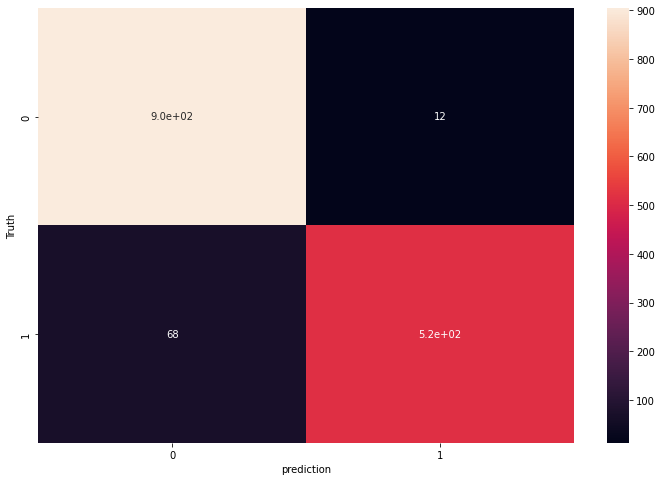

In [70]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion,annot=True)
plt.xlabel('prediction')
plt.ylabel('Truth')

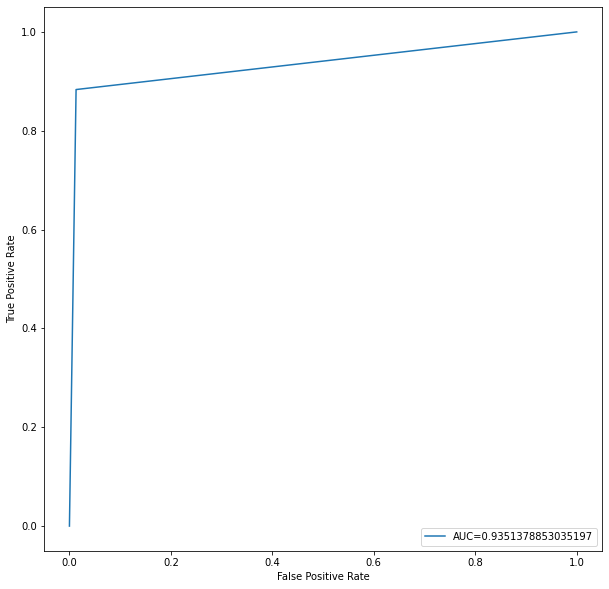

In [71]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()